# 감정분석 데이터셋 불러오기 및 전처리

In [ ]:
#변수설정 # gpu사용 변수
device = torch.device('cuda:3') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# 데이터 확인
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dataset 만들기
import keras
from keras.utils import to_categorical

# Detect Face
import cv2
from scipy.ndimage import zoom

# Model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import BatchNormalization
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

In [19]:
df = pd.read_csv("/content/drive/MyDrive/fer2013.csv")

In [20]:
# 이미지 픽셀 list로 만들기
df['pixels'] = df['pixels'].apply(lambda pixel: np.fromstring(pixel, sep=' '))
df.head()

,emotion,pixels,Usage
0,0,"[70.0, 80.0, 82.0, 72.0, 58.0, 58.0, 60.0, 63....",Training
1,0,"[151.0, 150.0, 147.0, 155.0, 148.0, 133.0, 111...",Training
2,2,"[231.0, 212.0, 156.0, 164.0, 174.0, 138.0, 161...",Training
3,4,"[24.0, 32.0, 36.0, 30.0, 32.0, 23.0, 19.0, 20....",Training
4,6,"[4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Training


In [21]:
# train test split
train_df = df[df['Usage']=='Training']
test_df = df[df['Usage']=='PublicTest']
print(train_df.shape)
print(test_df.shape)

(28709, 3)
(3589, 3)


In [22]:
# # 데이터프레임에서 train 및 test 데이터를 분할
# train_data = df[df['Usage'] == 'Training']
# test_data = df[df['Usage'] == 'PublicTest']

# # train 및 test 데이터를 CSV 파일로 저장해주는 코드인데 한번만 해도되서 주석처리
# train_data.to_csv('train_data.csv', index=False)
# test_data.to_csv('test_data.csv', index=False)

In [23]:
#data set array구조 reshape
shape_x = 48
shape_y = 48

# X_train, y_train, X_test, y_test split
X_train = train_df.iloc[:, 1].values # pixles
y_train = train_df.iloc[:, 0].values # emotion

X_test = test_df.iloc[:, 1].values # pixles
y_test = test_df.iloc[:, 0].values # emotion

# 전체데이터
X = df.iloc[:, 1].values # pixles
y = df.iloc[:, 0].values # emotion

# array([array([....])]) 구조를 바꾸기 위한 np.vstack
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)
X = np.vstack(X)

In [24]:
X_train.shape

(28709, 2304)

In [25]:
# 4차원 데이터셋 만들기 (데이터개수, x축, y축, rgb)
X_train_ds = np.reshape(X_train, (X_train.shape[0], shape_x, shape_y, 1))
y_train_ds = np.reshape(y_train, (y_train.shape[0], 1))

X_test_ds = np.reshape(X_test, (X_test.shape[0], shape_x, shape_y, 1))
y_test_ds = np.reshape(y_test, (y_test.shape[0], 1))

print(X_train_ds.shape, y_train_ds.shape)
print(X_test_ds.shape, y_test_ds.shape)

(28709, 48, 48, 1) (28709, 1)
(3589, 48, 48, 1) (3589, 1)


In [26]:
X_train_ds = np.repeat(X_train_ds, 3, axis=-1)
X_test_ds = np.repeat(X_test_ds, 3, axis=-1)
print(X_train_ds.shape)

(28709, 48, 48, 3)


mobiltnetv2는 흑백이 아닌 컬러이미지만을 input으로 받을 수 있음 그래서 채널수를 3으로 변경하는 과정을 추가했음

* resnet을 사용못한 이유 = 224,224,3의 이미지크기만을 input으로 넣을 수 있는데 기존 데이터셋 48,48,1에서 224,224,3으로 바꾸는 과정에서 계속해서 세션이 다운되는 문제 발생
하지만 mobilenetv2의 경우 채널수만 3으로 맞춰주면 다양한 형태의 이미지도 인풋으로 사용할 수 있고 resnet보다 훨씬 가벼운 모델이라 적합함:

In [27]:
# 데이터타입 float로 변경
train_data = X_train_ds.astype('float32')
test_data = X_test_ds.astype('float32')

# 스케일링
train_data /= 225
test_data /= 225

# y데이터 원핫인코딩
train_labels_onehot = to_categorical(y_train_ds)
test_labels_onehot = to_categorical(y_test_ds)

# input_shape 설정
n_rows, n_cols, n_dims = X_train_ds.shape[1:]
input_shape = (n_rows, n_cols, n_dims)
print(input_shape)

(48, 48, 3)


In [28]:
# 라벨 숫자를 문자로 변경
def get_label(argument):
    labels = {0:'angry', 1:'disgust', 2:'fear', 3:'happy', 4:'sad', 5:'surprise', 6:'neutral'}
    return(labels.get(argument, 'Invalid emotion'))

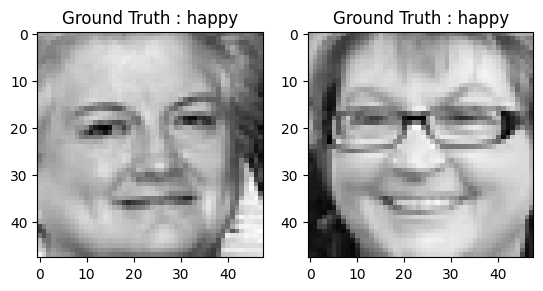

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Train data 중 100번째 이미지
n = 100

# RGB 색상 채널을 평균화하여 그레이스케일 이미지로 변환
gray_image_train = np.mean(X_train_ds[n, :, :, :], axis=2)

plt.subplot(121)
plt.imshow(gray_image_train, cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_train[n]))))

# Test data 중 100번째 이미지
# RGB 색상 채널을 평균화하여 그레이스케일 이미지로 변환
gray_image_test = np.mean(X_test_ds[n, :, :, :], axis=2)

plt.subplot(122)
plt.imshow(gray_image_test, cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_test[n]))))

plt.show()


# 얼굴 감지 함수

In [ ]:
#detect face
#얼굴 감지모델은 opencv의 cascade 사용 (미리다운받아놓음)
# 전체 이미지에서 얼굴을 찾아내는 함수
def detect_face(frame):

    # cascade pre-trained 모델 불러오기
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # RGB를 gray scale로 바꾸기
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # cascade 멀티스케일 분류
    detected_faces = face_cascade.detectMultiScale(gray,
                                                   scaleFactor = 1.1,
                                                   minNeighbors = 6,
                                                   minSize = (shape_x, shape_y),
                                                   flags = cv2.CASCADE_SCALE_IMAGE
                                                  )

    coord = []
    for x, y, w, h in detected_faces:
        if w > 100:
            sub_img = frame[y:y+h, x:x+w]
            coord.append([x, y, w, h])

    return gray, detected_faces, coord

In [ ]:
# 전체 이미지에서 찾아낸 얼굴을 추출하는 함수
def extract_face_features(gray, detected_faces, coord, offset_coefficients=(0.075, 0.05)):
    new_face = []
    for det in detected_faces:

        # 얼굴로 감지된 영역
        x, y, w, h = det

        # 이미지 경계값 받기
        horizontal_offset = np.int(np.floor(offset_coefficients[0] * w))
        vertical_offset = np.int(np.floor(offset_coefficients[1] * h))

        # gray scacle 에서 해당 위치 가져오기
        extracted_face = gray[y+vertical_offset:y+h, x+horizontal_offset:x-horizontal_offset+w]

        # 얼굴 이미지만 확대
        new_extracted_face = zoom(extracted_face, (shape_x/extracted_face.shape[0], shape_y/extracted_face.shape[1]))
        new_extracted_face = new_extracted_face.astype(np.float32)
        new_extracted_face /= float(new_extracted_face.max()) # sacled
        new_face.append(new_extracted_face)

    return new_face

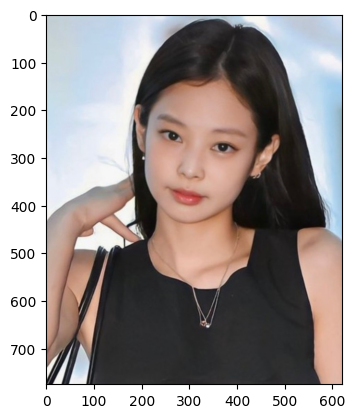

In [ ]:
jenny = cv2.imread("/content/제니.jpeg")
plt.imshow(cv2.cvtColor(jenny, cv2.COLOR_BGR2RGB))

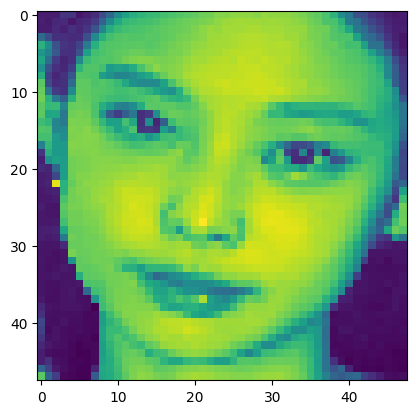

In [ ]:
# 얼굴 찾기
gray, detected_faces, coord = detect_face(jenny)

# 찾은 얼굴 추출하기
face_zoom = extract_face_features(gray, detected_faces, coord)

# 시각화
plt.imshow(face_zoom[0])

# 감정분석 모델

In [ ]:
#감정분석 모델 구축 라인

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

def mobilenetv2_model(input_shape):
    # MobileNetV2 모델 불러오기 (사전 학습)
    mobilenetv2_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    # 재학습을 막기 위한 코드
    for layer in mobilenetv2_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(mobilenetv2_model)

    # GlobalAveragePooling2D를 사용하여 Flatten 대신 사용
    model.add(GlobalAveragePooling2D())

    # Fully connected layer
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))

    # Output layer with 7 classes
    model.add(Dense(7, activation='softmax'))

    return model

# 입력 이미지의 shape을 지정하세요 (예: (224, 224, 3))
input_shape = (48, 48, 3)

# MobileNetV2 모델 생성
model = mobilenetv2_model(input_shape)

# 모델 요약 출력
model.summary()




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 2, 2, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_2 (Dense)             (None, 512)               655872    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 2917447 (11.13 MB)
Trainable params: 659

In [ ]:
# 이미지 데이터 증강
datagen = ImageDataGenerator(zoom_range=0.2,          # 랜덤하게 이미지 줌 하는 비율
                             rotation_range=10,       # 랜덤하게 이미지 회전하는 비율 (0도~180도)
                             width_shift_range=0.1,   # 랜덤하게 이미지 가로로 이동하는 비율
                             height_shift_range=0.1,  # 랜덤하게 이미지 세로로 이동하는 비율
                             horizontal_flip=True,    # 랜덤하게 이미지 수평 뒤집기
                             vertical_flip=False)     # 랜덤하게 이미지 수직 뒤집기

# 모델 학습을 위한 파라미터 설정
batch_size = 256
n_epochs = 100
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(datagen.flow(train_data, train_labels_onehot, batch_size=batch_size),
                              steps_per_epoch=int(np.ceil(train_data.shape[0]/float(batch_size))),
                              epochs=n_epochs,
                              validation_data=(test_data, test_labels_onehot)
                             )

Epoch 1/100
113/113 [==============================] - 94s 790ms/step - loss: 1.7495 - accuracy: 0.3153 - val_loss: 1.6422 - val_accuracy: 0.3408
Epoch 2/100
113/113 [==============================] - 95s 836ms/step - loss: 1.6338 - accuracy: 0.3519 - val_loss: 1.5787 - val_accuracy: 0.3828
Epoch 3/100
113/113 [==============================] - 95s 835ms/step - loss: 1.6100 - accuracy: 0.3667 - val_loss: 1.5628 - val_accuracy: 0.3870
Epoch 4/100
113/113 [==============================] - 91s 804ms/step - loss: 1.5964 - accuracy: 0.3712 - val_loss: 1.5574 - val_accuracy: 0.3904
Epoch 5/100
113/113 [==============================] - 96s 850ms/step - loss: 1.5874 - accuracy: 0.3747 - val_loss: 1.5562 - val_accuracy: 0.3904
Epoch 6/100
113/113 [==============================] - 115s 1s/step - loss: 1.5716 - accuracy: 0.3849 - val_loss: 1.5472 - val_accuracy: 0.3970
Epoch 7/100
113/113 [==============================] - 92s 808ms/step - loss: 1.5680 - accuracy: 0.3858 - val_loss: 1.5472 - v

In [ ]:
# 모델을 저장할 경로 및 파일명 정의
model_save_path = '/content/drive/MyDrive/model_sentiment_prediction.h5'

# 모델 저장
model.save(model_save_path)


# 나이와 성별 판별에 필요한 데이터셋과 라이브러리 import

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import tarfile
import os

# 압축 파일과 압축을 풀 폴더의 경로 설정
tar_path = '/content/drive/MyDrive/part1.tar.gz'
extract_path = '/content/drive/MyDrive/'

# tar.gz 파일 압축 해제
with tarfile.open(tar_path, 'r:gz') as tar:
    tar.extractall(extract_path)



EOFError: ignored

In [12]:
extract_path = '/content/drive/MyDrive/part1'

In [13]:
import os

# 해제된 파일 목록 확인
extracted_files = os.listdir(extract_path)
print(extracted_files)


['2_1_2_20161219202547820.jpg', '77_1_0_20170110122639530.jpg', '1_1_0_20170109190844250.jpg', '29_1_2_20170105164315483.jpg', '76_1_0_20170110131744527.jpg', '50_1_0_20170110154254311.jpg', '2_1_2_20161219152918020.jpg', '5_1_0_20170109194229104.jpg', '81_1_2_20170105174804349.jpg', '30_0_0_20170105164847516.jpg', '37_1_0_20170104171729234.jpg', '17_0_0_20170104003852806.jpg', '46_0_3_20170104210508188.jpg', '32_1_3_20170104223515310.jpg', '5_1_2_20161219151834275.jpg', '32_0_4_20170105163336092.jpg', '1_1_4_20170103210113314.jpg', '8_1_0_20170109203557851.jpg', '38_0_2_20170104194407752.jpg', '1_0_2_20161219155850477.jpg', '15_0_0_20170110232515682.jpg', '8_0_0_20170110222913531.jpg', '30_1_0_20170104165921257.jpg', '15_1_2_20170104013425867.jpg', '5_1_2_20161219200433267.jpg', '1_0_2_20161219212229166.jpg', '24_1_3_20170104231625010.jpg', '1_0_2_20161219154038141.jpg', '9_0_0_20170110224819698.jpg', '32_0_4_20170104170633305.jpg', '34_0_0_20170104170059137.jpg', '29_0_2_201701041929

In [16]:
import os
import pandas as pd

# 데이터셋 폴더 경로
dataset_folder = '/content/drive/MyDrive/part1'

# 데이터를 저장할 데이터프레임 생성
df = pd.DataFrame(columns=['age', 'gender', 'race', 'filename'])

# 이미지 파일들의 경로
image_paths = [os.path.join(dataset_folder, filename) for filename in os.listdir(dataset_folder) if filename.endswith('.jpg')]

# 파일명을 파싱하여 데이터프레임에 추가
for image_path in image_paths:
    filename = os.path.basename(image_path)
    parts = os.path.splitext(filename)[0].split('_')

    # 파일명에서 정보 추출
    age = int(parts[0])
    gender = int(parts[1])
    race = int(parts[2])

    # 데이터프레임에 추가
    df = df.append({'age': age, 'gender': gender, 'race': race, 'filename': filename}, ignore_index=True)

# 데이터프레임 출력
print(df.head())

# CSV 파일로 저장
csv_path = '/content/drive/MyDrive/dataset_info.csv'
df.to_csv(csv_path, index=False)

print("데이터셋 정보가 저장되었습니다.")


  age gender race                      filename
0   2      1    2   2_1_2_20161219202547820.jpg
1  77      1    0  77_1_0_20170110122639530.jpg
2   1      1    0   1_1_0_20170109190844250.jpg
3  29      1    2  29_1_2_20170105164315483.jpg
4  76      1    0  76_1_0_20170110131744527.jpg
데이터셋 정보가 저장되었습니다.


In [17]:
image_dataset_age = pd.read_csv('/content/drive/MyDrive/dataset_info.csv')
image_dataset_age

,age,gender,race,filename
0,2,1,2,2_1_2_20161219202547820.jpg
1,77,1,0,77_1_0_20170110122639530.jpg
2,1,1,0,1_1_0_20170109190844250.jpg
3,29,1,2,29_1_2_20170105164315483.jpg
4,76,1,0,76_1_0_20170110131744527.jpg
...,...,...,...,...
908,1,0,2,1_0_2_20161219201528716.jpg
909,53,0,0,53_0_0_20170109012721891.jpg
910,99,1,2,99_1_2_20170110182418864.jpg
911,52,1,0,52_1_0_20170105173045268.jpg


# 나이 판별 모델

In [37]:
import pandas as pd
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import numpy as np
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, Dropout

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/dataset_info.csv')  # Replace 'your_dataset.csv' with the actual path to your dataset

# Assuming you have the images stored in '/content/drive/MyDrive/part1/'
image_folder_path = '/content/drive/MyDrive/part1/'

from PIL import Image

def load_and_preprocess_image(filename):
    try:
        img = Image.open(image_folder_path + filename)
        img = img.convert('RGB')  # 이미지를 RGB 모드로 변환
        img = img.resize((48, 48))  # 원하는 크기로 이미지 크기 조정
        img_array = np.array(img)
        img_array = img_array / 255.0  # 픽셀 값을 0에서 1 사이로 정규화
        return img_array
    except Exception as e:
        print(f"이미지 {filename} 로드 중 오류 발생: {str(e)}")
        return None

# 데이터프레임의 모든 파일 이름에 전처리 함수를 적용합니다.
df['image'] = df['filename'].apply(load_and_preprocess_image)

# None 항목을 필터링합니다.
df = df.dropna()

# 'image' 열을 numpy 배열로 변환합니다.
X = np.stack(df['image'].to_numpy())

# Apply the preprocessing function to all filenames in the dataframe
df['image'] = df['filename'].apply(load_and_preprocess_image)

# Convert the 'image' column to a numpy array
X = np.stack(df['image'].to_numpy())

# Extract the labels
y = df['age'].to_numpy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
input_shape = (48, 48, 3)
input_layer = Input(shape=input_shape)

# ... (your model architecture)
input = Input(shape=(48, 48, 3))

cnn1 = Conv2D(128, kernel_size=3, activation='relu')(input)
cnn1 = Conv2D(128, kernel_size=3, activation='relu')(cnn1)
cnn1 = Conv2D(128, kernel_size=3, activation='relu')(cnn1)
cnn1 = MaxPool2D(pool_size=3, strides=2)(cnn1)

cnn2 = Conv2D(128, kernel_size=3, activation='relu')(cnn1)
cnn2 = Conv2D(128, kernel_size=3, activation='relu')(cnn2)
cnn2 = Conv2D(128, kernel_size=3, activation='relu')(cnn2)
cnn2 = MaxPool2D(pool_size=3, strides=2)(cnn2)

dense = Flatten()(cnn2)
dense = Dropout(0.2)(dense)
dense = Dense(1024, activation='relu')(dense)
dense = Dense(1024, activation='relu')(dense)

output = Dense(1, activation='linear', name='age')(dense)

model_age = Model(input, output)
model_age.compile(optimizer=Adam(0.0001), loss='mse', metrics=['mae'])


# Compile the model
model_age.compile(optimizer=Adam(0.0001), loss='mse', metrics=['mae'])

# Train the model
model_age.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))


이미지 18_1_3_20170109214031495.jpg 로드 중 오류 발생: image file is truncated (6 bytes not processed)
Epoch 1/10
23/23 [==============================] - 87s 4s/step - loss: 1125.9065 - mae: 25.8151 - val_loss: 751.1222 - val_mae: 21.8365
Epoch 2/10
23/23 [==============================] - 93s 4s/step - loss: 765.2559 - mae: 23.0534 - val_loss: 724.0901 - val_mae: 21.2816
Epoch 3/10
23/23 [==============================] - 106s 5s/step - loss: 748.2078 - mae: 22.7437 - val_loss: 664.0922 - val_mae: 20.6727
Epoch 4/10
23/23 [==============================] - 80s 4s/step - loss: 729.8766 - mae: 22.4468 - val_loss: 602.9703 - val_mae: 20.4610
Epoch 5/10
23/23 [==============================] - 82s 4s/step - loss: 706.0555 - mae: 21.8444 - val_loss: 697.6638 - val_mae: 20.5428
Epoch 6/10
23/23 [==============================] - 83s 3s/step - loss: 719.9776 - mae: 22.0729 - val_loss: 586.7486 - val_mae: 20.2913
Epoch 7/10
23/23 [==============================] - 78s 3s/step - loss: 659.5536 - mae: 2

In [38]:
# Evaluate the model on the test set
results = model_age.evaluate(X_test, y_test, batch_size=32)

# Print the evaluation results
print("Test Loss:", results[0])
print("Test MAE (Mean Absolute Error):", results[1])


6/6 [==============================] - 5s 799ms/step - loss: 595.9330 - mae: 19.9340
Test Loss: 595.9329833984375
Test MAE (Mean Absolute Error): 19.93398094177246


In [39]:
# 예측을 얻기 위해 모델을 사용
sample_index = 0  # 테스트 셋에서 확인하고 싶은 이미지의 인덱스
sample_image = X_test[sample_index].reshape(1, 48, 48, 3)  # 배치 차원 추가

# 예측 수행
prediction = model_age.predict(sample_image)

# 예측 결과 출력
print("실제 나이:", y_test[sample_index])
print("모델 예측 나이:", prediction[0, 0])


1/1 [==============================] - 0s 434ms/step
실제 나이: 42
모델 예측 나이: 28.91879


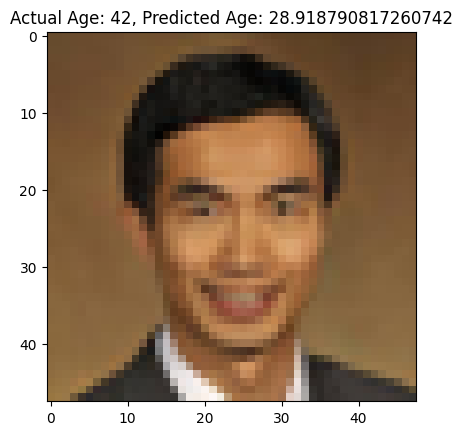

In [41]:
plt.imshow(X_test[sample_index])
plt.title(f"Actual Age: {y_test[sample_index]}, Predicted Age: {prediction[0, 0]}")
plt.show()

In [56]:
# 모델 저장

# 모델을 저장할 경로 및 파일명 정의
model_save_path = '/content/drive/MyDrive/model_age_prediction.h5'

# 모델 저장
model_age.save(model_save_path)


# 성별 판별 모델

In [44]:
import pandas as pd
from keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import numpy as np
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, Dropout

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/dataset_info.csv')  # Replace 'your_dataset.csv' with the actual path to your dataset

# Assuming you have the images stored in '/content/drive/MyDrive/part1/'
image_folder_path = '/content/drive/MyDrive/part1/'

from PIL import Image

def load_and_preprocess_image(filename):
    try:
        img = Image.open(image_folder_path + filename)
        img = img.convert('RGB')  # 이미지를 RGB 모드로 변환
        img = img.resize((48, 48))  # 원하는 크기로 이미지 크기 조정
        img_array = np.array(img)
        img_array = img_array / 255.0  # 픽셀 값을 0에서 1 사이로 정규화
        return img_array
    except Exception as e:
        print(f"이미지 {filename} 로드 중 오류 발생: {str(e)}")
        return None

# 데이터프레임의 모든 파일 이름에 전처리 함수를 적용합니다.
df['image'] = df['filename'].apply(load_and_preprocess_image)

# None 항목을 필터링합니다.
df = df.dropna()

# 'image' 열을 numpy 배열로 변환합니다.
X = np.stack(df['image'].to_numpy())

# Apply the preprocessing function to all filenames in the dataframe
df['image'] = df['filename'].apply(load_and_preprocess_image)

# Convert the 'image' column to a numpy array
X = np.stack(df['image'].to_numpy())

# Extract the labels
y = df['gender'].to_numpy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model
input_shape = (48, 48, 3)
input_layer = Input(shape=input_shape)

# ... (your model architecture)
cnn1 = Conv2D(36, kernel_size=3, activation='relu')(input)
cnn1 = MaxPool2D(pool_size=3, strides=2)(cnn1)
cnn2 = Conv2D(64, kernel_size=3, activation='relu')(cnn1)
cnn2 = MaxPool2D(pool_size=3, strides=2)(cnn2)
cnn3 = Conv2D(128, kernel_size=3, activation='relu')(cnn2)
cnn3 = MaxPool2D(pool_size=3, strides=2)(cnn3)

dense = Flatten()(cnn3)
dense = Dropout(0.2)(dense)
dense = Dense(512, activation='relu')(dense)
dense = Dense(512, activation='relu')(dense)
output = Dense(1, activation='sigmoid', name='gender')(dense)
model_sex = Model(input, output)
model_sex.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])


# Train the model
model_sex.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

이미지 18_1_3_20170109214031495.jpg 로드 중 오류 발생: image file is truncated (6 bytes not processed)
Epoch 1/10
23/23 [==============================] - 4s 138ms/step - loss: 0.6864 - accuracy: 0.5569 - val_loss: 0.6720 - val_accuracy: 0.6011
Epoch 2/10
23/23 [==============================] - 5s 202ms/step - loss: 0.6851 - accuracy: 0.5665 - val_loss: 0.6698 - val_accuracy: 0.6011
Epoch 3/10
23/23 [==============================] - 5s 212ms/step - loss: 0.6792 - accuracy: 0.5665 - val_loss: 0.6706 - val_accuracy: 0.6011
Epoch 4/10
23/23 [==============================] - 3s 134ms/step - loss: 0.6783 - accuracy: 0.5748 - val_loss: 0.6654 - val_accuracy: 0.6011
Epoch 5/10
23/23 [==============================] - 3s 148ms/step - loss: 0.6701 - accuracy: 0.5665 - val_loss: 0.6662 - val_accuracy: 0.6120
Epoch 6/10
23/23 [==============================] - 3s 142ms/step - loss: 0.6600 - accuracy: 0.5844 - val_loss: 0.6590 - val_accuracy: 0.6175
Epoch 7/10
23/23 [==============================] - 5s 

In [45]:
# Evaluate the model on the test set
results = model_age.evaluate(X_test, y_test, batch_size=32)

# Print the evaluation results
print("Test Loss:", results[0])
print("Test MAE (Mean Absolute Error):", results[1])


6/6 [==============================] - 4s 686ms/step - loss: 904.4649 - mae: 28.4714
Test Loss: 904.4649047851562
Test MAE (Mean Absolute Error): 28.471351623535156


In [54]:
# 예측을 얻기 위해 모델을 사용
sample_index = 0  # 테스트 셋에서 확인하고 싶은 이미지의 인덱스
sample_image = X_test[sample_index].reshape(1, 48, 48, 3)  # 배치 차원 추가

# 예측 수행
prediction = model_sex.predict(sample_image)

# 예측 결과 출력
print("실제 성별:", y_test[sample_index])
print("모델 예측 성별:", prediction[0, 0])

1/1 [==============================] - 0s 23ms/step
실제 성별: 0
모델 예측 성별: 0.6559191


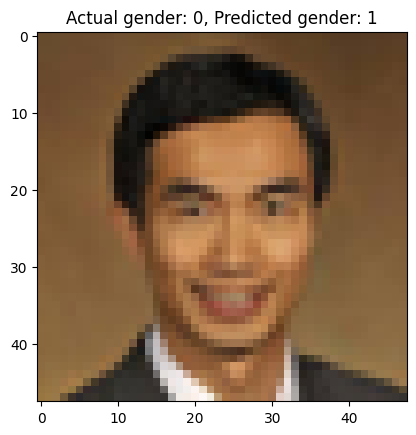

In [55]:
# 예측값을 0과 1 이진값으로 나오게 변환
prediction = (prediction > 0.5).astype(int)

plt.imshow(X_test[sample_index])
plt.title(f"Actual gender: {y_test[sample_index]}, Predicted gender: {prediction[0, 0]}")
plt.show()

In [57]:
# 모델을 저장할 경로 및 파일명 정의
model_save_path = '/content/drive/MyDrive/model_sex_prediction.h5'

# 모델 저장
model_sex.save(model_save_path)

